In [46]:
import numpy as np # linear 
from numpy import concatenate
from math import sqrt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame
from pandas import concat
from datetime import datetime
import matplotlib.pyplot as pyplot
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

## Glimpse Data

Read data

In [47]:
btc = pd.read_csv('/data/training.csv')
btc.set_index('Timestamp')

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,TDA
Timestamp,,,,,,,,
2017-01-03 04:00:00,1023.315250,1023.436750,1023.267500,1023.392250,2.499811,2557.745244,1023.345857,1.512730
2017-01-03 05:00:00,1022.452955,1022.454318,1022.223636,1022.261591,5.433221,5556.951296,1022.299328,1.521520
2017-01-03 06:00:00,1017.268864,1017.485000,1016.845000,1017.320909,6.754669,6875.645449,1017.148655,0.889232
2017-01-03 07:00:00,1012.305532,1012.549574,1012.033617,1012.318936,3.272033,3311.363934,1012.258033,1.018090
2017-01-03 08:00:00,1014.850638,1015.312128,1014.587660,1015.101064,3.856818,3917.441456,1014.977552,1.017370
...,...,...,...,...,...,...,...,...
2020-12-30 20:00:00,28804.122167,28826.711333,28777.034000,28805.678000,12.649963,364479.654389,28801.783950,3884.190000
2020-12-30 21:00:00,28840.522833,28862.506833,28812.956333,28843.839833,7.912897,227921.940911,28837.869651,4046.840000
2020-12-30 22:00:00,28820.040500,28837.640500,28795.527000,28816.996833,3.954189,113881.747431,28816.717681,2762.500000


Select an eventful time period in Bitcoin history

In [48]:
# Select the years 2017 on
btc = btc.loc['2010':]

#### Time resampling

In [49]:
btc.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,TDA
20100,2019-04-20 16:00:00,5324.226897,5325.084310,5323.238276,5324.239310,0.958748,5106.092381,5324.267107,21.7167
20101,2019-04-20 17:00:00,5315.988966,5317.052414,5314.585345,5315.913793,4.065730,21606.853254,5315.689465,20.8140
20102,2019-04-20 18:00:00,5311.773455,5312.570727,5311.106364,5311.963091,1.066115,5662.866689,5311.725131,13.2219
20103,2019-04-20 19:00:00,5318.488542,5319.456875,5318.088542,5319.093542,1.200785,6387.066892,5318.750702,13.8803
20104,2019-04-20 20:00:00,5322.951500,5324.086000,5321.700000,5322.936333,1.830436,9734.838371,5322.753415,11.3486


#### Plot time series

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

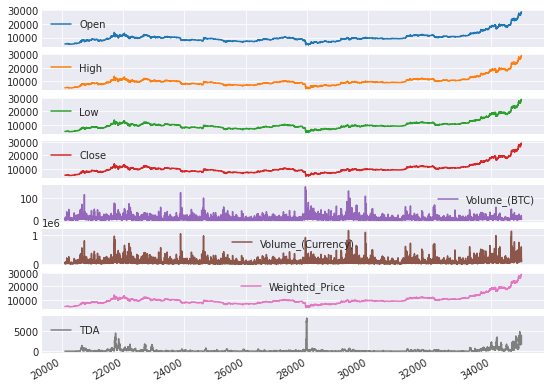

In [50]:
btc.plot(figsize=(9,7), subplots=True)

#### Keras Long Short-Term Memory (LSTM) Model

In [51]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    print(data)
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [70]:
# load dataset
values = btc.drop(columns=['Timestamp', 'Open', 'High', 'Low', 'Volume_(Currency)', 'Weighted_Price']).values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

[[0.03180531 0.00632798 0.00253486]
 [0.03146381 0.02721717 0.00242719]
 [0.03130176 0.00704984 0.00152162]
 ...
 [0.99542679 0.02646724 0.32945082]
 [0.99511055 0.01584663 0.23520189]
 [1.         0.03859266 0.2095332 ]]


In [71]:
ncols = reframed.shape[1]

In [72]:
print(reframed)
print(ncols)

       var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
1       0.031805   0.006328   0.002535  0.031464  0.027217  0.002427
2       0.031464   0.027217   0.002427  0.031302  0.007050  0.001522
3       0.031302   0.007050   0.001522  0.031594  0.007955  0.001600
4       0.031594   0.007955   0.001600  0.031752  0.012189  0.001298
5       0.031752   0.012189   0.001298  0.030780  0.023024  0.001298
...          ...        ...        ...       ...       ...       ...
14884   0.993102   0.135813   0.459067  0.994963  0.084932  0.463244
14885   0.994963   0.084932   0.463244  0.996528  0.053083  0.482645
14886   0.996528   0.053083   0.482645  0.995427  0.026467  0.329451
14887   0.995427   0.026467   0.329451  0.995111  0.015847  0.235202
14888   0.995111   0.015847   0.235202  1.000000  0.038593  0.209533

[14888 rows x 6 columns]
6


In [73]:

reframed.drop(reframed.columns[[ncols-1,ncols-3]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var2(t)
1   0.031805   0.006328   0.002535  0.027217
2   0.031464   0.027217   0.002427  0.007050
3   0.031302   0.007050   0.001522  0.007955
4   0.031594   0.007955   0.001600  0.012189
5   0.031752   0.012189   0.001298  0.023024


In [95]:
# split into train and test sets
values = reframed.values
n_test_hours = 90 * 24
n_train_hours = values.shape[0] - n_test_hours
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(12728, 1, 3) (12728,) (2160, 1, 3) (2160,)


In [85]:
print(test_X.shape)

(2160, 1, 3)


In [76]:

# design network
#model = Sequential()
#model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

regressor = Sequential()

regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50))
#regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = regressor.fit(train_X, train_y, epochs = 340, batch_size = 32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/340
398/398 - 1s - loss: 0.0032 - val_loss: 0.0013
Epoch 2/340
398/398 - 1s - loss: 0.0027 - val_loss: 0.0012
Epoch 3/340
398/398 - 1s - loss: 0.0025 - val_loss: 0.0012
Epoch 4/340
398/398 - 1s - loss: 0.0022 - val_loss: 0.0011
Epoch 5/340
398/398 - 1s - loss: 0.0020 - val_loss: 0.0011
Epoch 6/340
398/398 - 1s - loss: 0.0020 - val_loss: 0.0011
Epoch 7/340
398/398 - 1s - loss: 0.0020 - val_loss: 0.0011
Epoch 8/340
398/398 - 1s - loss: 0.0020 - val_loss: 0.0011
Epoch 9/340
398/398 - 1s - loss: 0.0020 - val_loss: 0.0010
Epoch 10/340
398/398 - 1s - loss: 0.0020 - val_loss: 0.0010
Epoch 11/340
398/398 - 1s - loss: 0.0020 - val_loss: 9.9192e-04
Epoch 12/340
398/398 - 1s - loss: 0.0020 - val_loss: 9.8213e-04
Epoch 13/340
398/398 - 1s - loss: 0.0020 - val_loss: 9.3960e-04
Epoch 14/340
398/398 - 1s - loss: 0.0020 - val_loss: 9.5715e-04
Epoch 15/340
398/398 - 2s - loss: 0.0019 - val_loss: 9.1867e-04
Epoch 16/340
398/398 - 1s - loss: 0.0019 - val_loss: 9.1029e-04
Epoch 17/340
398/398 - 1s

Epoch 130/340
398/398 - 1s - loss: 0.0019 - val_loss: 9.0096e-04
Epoch 131/340
398/398 - 1s - loss: 0.0019 - val_loss: 8.9918e-04
Epoch 132/340
398/398 - 1s - loss: 0.0019 - val_loss: 8.9293e-04
Epoch 133/340
398/398 - 1s - loss: 0.0019 - val_loss: 8.9413e-04
Epoch 134/340
398/398 - 1s - loss: 0.0019 - val_loss: 8.9952e-04
Epoch 135/340
398/398 - 1s - loss: 0.0019 - val_loss: 8.9918e-04
Epoch 136/340
398/398 - 1s - loss: 0.0019 - val_loss: 8.9585e-04
Epoch 137/340
398/398 - 2s - loss: 0.0019 - val_loss: 8.9889e-04
Epoch 138/340
398/398 - 2s - loss: 0.0019 - val_loss: 8.9651e-04
Epoch 139/340
398/398 - 1s - loss: 0.0019 - val_loss: 8.9364e-04
Epoch 140/340
398/398 - 1s - loss: 0.0019 - val_loss: 8.9424e-04
Epoch 141/340
398/398 - 1s - loss: 0.0019 - val_loss: 8.9455e-04
Epoch 142/340
398/398 - 1s - loss: 0.0019 - val_loss: 8.9490e-04
Epoch 143/340
398/398 - 2s - loss: 0.0019 - val_loss: 8.9675e-04
Epoch 144/340
398/398 - 2s - loss: 0.0019 - val_loss: 8.9883e-04
Epoch 145/340
398/398 - 1

398/398 - 2s - loss: 0.0019 - val_loss: 9.0288e-04
Epoch 257/340
398/398 - 2s - loss: 0.0019 - val_loss: 8.9766e-04
Epoch 258/340
398/398 - 1s - loss: 0.0019 - val_loss: 9.0482e-04
Epoch 259/340
398/398 - 2s - loss: 0.0019 - val_loss: 9.0536e-04
Epoch 260/340
398/398 - 2s - loss: 0.0019 - val_loss: 9.0486e-04
Epoch 261/340
398/398 - 2s - loss: 0.0019 - val_loss: 9.0106e-04
Epoch 262/340
398/398 - 1s - loss: 0.0019 - val_loss: 9.0384e-04
Epoch 263/340
398/398 - 2s - loss: 0.0019 - val_loss: 9.0930e-04
Epoch 264/340
398/398 - 2s - loss: 0.0019 - val_loss: 9.0422e-04
Epoch 265/340
398/398 - 1s - loss: 0.0019 - val_loss: 9.1040e-04
Epoch 266/340
398/398 - 1s - loss: 0.0019 - val_loss: 9.0755e-04
Epoch 267/340
398/398 - 1s - loss: 0.0019 - val_loss: 9.0541e-04
Epoch 268/340
398/398 - 3s - loss: 0.0019 - val_loss: 9.0465e-04
Epoch 269/340
398/398 - 1s - loss: 0.0019 - val_loss: 9.0477e-04
Epoch 270/340
398/398 - 1s - loss: 0.0019 - val_loss: 9.0361e-04
Epoch 271/340
398/398 - 1s - loss: 0.00

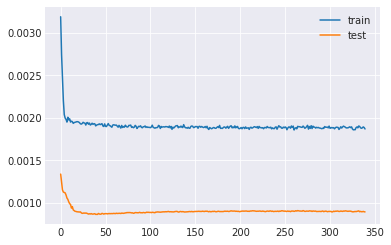

In [77]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [96]:
print(test_X.shape)
print(train_X.shape)

(2160, 1, 3)
(12728, 1, 3)


In [97]:
yhat = regressor.predict(test_X)

In [99]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [100]:
print(test_X)
print(yhat)

[[0.2482426  0.03262661 0.00429447]
 [0.24831803 0.00881971 0.00440102]
 [0.24829172 0.01230666 0.00427696]
 ...
 [0.99652784 0.05308284 0.48264471]
 [0.99542679 0.02646724 0.32945082]
 [0.99511055 0.01584663 0.23520189]]
[[[0.02906824]]

 [[0.01732941]]

 [[0.01902448]]

 ...

 [[0.04658044]]

 [[0.04158433]]

 [[0.03790485]]]


In [104]:
print(yhat.shape)
print(test_X[:, 1:].shape)
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]
#print(inv_yhat)
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)

(2160, 1, 1)
(2160, 2)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)